In [1]:
# !pip install anndata

In [82]:
import numpy as np
import pandas as pd
import tqdm as tq
import anndata as ad
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix

In [83]:
import matplotlib.pyplot as plt

# Preprocess data

In [84]:
DATA = "data"

In [85]:
df_train = pd.read_parquet(f"{DATA}/adata_train.parquet", engine="pyarrow")

In [86]:
# df_train["count"] = df_train[["count"]].astype(float)

In [87]:
df_train.head()

,obs_id,gene,count,normalized_count
0,000006a87ba75b72,AATF,1,5.567933
1,000006a87ba75b72,ABHD12,1,5.567933
2,000006a87ba75b72,ABHD3,1,5.567933
3,000006a87ba75b72,AC004687.1,1,5.567933
4,000006a87ba75b72,AC009779.2,1,5.567933


In [88]:
# df_train = df_train.head(1000000)
# df_train_h = df_train

In [89]:
df_train['obs_id'] = df_train['obs_id'].astype('category')
X_train = csr_matrix((df_train["count"], (df_train["obs_id"].cat.codes, pd.Categorical(df_train["gene"]).codes)))
# X_train = csr_matrix((df_train["normalized_count"], (df_train["obs_id"].cat.codes, pd.Categorical(df_train["gene"]).codes)))

In [90]:
X_train.shape

(240090, 21255)

In [91]:
ad_train = ad.AnnData(X_train)

In [92]:
ad_train.obs_names = df_train["obs_id"].cat.categories
ad_train.var_names = pd.Categorical(df_train["gene"]).categories

In [93]:
df_train_meta = pd.read_csv(f"{DATA}/adata_obs_meta.csv")

In [94]:
df_train_meta.head()

,obs_id,library_id,plate_name,well,row,col,cell_id,donor_id,cell_type,sm_lincs_id,sm_name,SMILES,dose_uM,timepoint_hr,control
0,000006a87ba75b72,library_4,plate_4,F7,F,7,PBMC,donor_2,T cells CD4+,LSM-4944,MLN 2238,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,1.0,24,False
1,0000233976e3cd37,library_0,plate_3,D4,D,4,PBMC,donor_1,T cells CD4+,LSM-46203,BMS-265246,CCCCOc1c(C(=O)c2c(F)cc(C)cc2F)cnc2[nH]ncc12,1.0,24,False
2,0001533c5e876362,library_2,plate_0,B11,B,11,PBMC,donor_0,T regulatory cells,LSM-45663,Resminostat,CN(C)Cc1ccc(S(=O)(=O)n2ccc(/C=C/C(=O)NO)c2)cc1,1.0,24,False
3,00022f989630d14b,library_35,plate_2,E6,E,6,PBMC,donor_0,T cells CD4+,LSM-43216,FK 866,O=C(/C=C/c1cccnc1)NCCCCC1CCN(C(=O)c2ccccc2)CC1,1.0,24,False
4,0002560bd38ce03e,library_22,plate_4,B6,B,6,PBMC,donor_2,T cells CD4+,LSM-1099,Nilotinib,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,1.0,24,False


In [95]:
df_train_meta.plate_name.unique()

array(['plate_4', 'plate_3', 'plate_0', 'plate_2', 'plate_1', 'plate_5'],
      dtype=object)

In [96]:
df_train_meta.shape

(240090, 15)

In [97]:
df_train_meta.cell_type.unique()

array(['T cells CD4+', 'T regulatory cells', 'T cells CD8+', 'NK cells',
       'B cells', 'Myeloid cells'], dtype=object)

In [98]:
ad_train.obs["cell_type"] = pd.Categorical(df_train_meta.cell_type)
ad_train.obs["sm_name"] = pd.Categorical(df_train_meta.sm_name)
ad_train.obs["donor_id"] = pd.Categorical(df_train_meta.donor_id)
ad_train.obs["library_id"] = pd.Categorical(df_train_meta.library_id)
ad_train.obs["control"] = pd.Categorical(df_train_meta.control)

In [99]:
ad_train

AnnData object with n_obs × n_vars = 240090 × 21255
    obs: 'cell_type', 'sm_name', 'donor_id', 'library_id', 'control'

In [100]:
# Select genes present in bulk dataset
de_train = pd.read_parquet(f"{DATA}/de_train.parquet")
bulk_genes = de_train.columns[5:]
len(bulk_genes)

18211

In [101]:
de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [78]:
#de_train.loc[de_train.control==True]

In [104]:
# Leave only bulk genes
ad_train = ad_train[:,bulk_genes]

In [105]:
pos_ctr = ["Dabrafenib", "Belinostat"]
neg_ctr = ["Dimethyl Sulfoxide"]

In [106]:
# Drop positive control samples
ad_train = ad_train[~ad_train.obs.sm_name.isin(pos_ctr),:]

In [107]:
# All data for bulk genes, no positive controls
ad_train.write(f"{DATA}/ad_train.h5ad", compression="gzip")

In [108]:
test_specs = [
	('T cells CD8+', ['Buspirone', 'Mometasone Furoate', 'Vandetanib', 'Saracatinib', 'Amiodarone']),
	('B cells', ['Crizotinib', 'Palbociclib', 'Linagliptin', 'Ixabepilone', 'LDN 193189']),
	('Myeloid cells', ['Idelalisib', 'R428', 'CHIR-99021', 'Foretinib', 'Penfluridol'])
]


In [110]:
test_cell_types = [a for a, _ in test_specs]

ad_test_list = []
ad_train_list = [ad_train[~ad_train.obs.cell_type.isin(test_cell_types)]]

ad_test_cell_types_pool = ad_train[ad_train.obs.cell_type.isin(test_cell_types)]

for cell_type, sm_names in test_specs:
    ad_single_cell_type = ad_test_cell_types_pool[ad_test_cell_types_pool.obs.cell_type == cell_type]
    ad_test_list.append(ad_single_cell_type[ad_single_cell_type.obs.sm_name.isin(sm_names)])
    ad_train_list.append(ad_single_cell_type[~ad_single_cell_type.obs.sm_name.isin(sm_names)])

ad_test = ad.concat(ad_test_list)
ad_train = ad.concat(ad_train_list)
    

In [113]:
ad_train.write(f"{DATA}/ad_train_split.h5ad", compression="gzip")

In [114]:
ad_test.write(f"{DATA}/ad_test_split.h5ad", compression="gzip")

In [116]:
sorted(ad_test.obs.sm_name.unique())

['Amiodarone',
 'Buspirone',
 'CHIR-99021',
 'Crizotinib',
 'Foretinib',
 'Idelalisib',
 'LDN 193189',
 'Linagliptin',
 'Mometasone Furoate',
 'Palbociclib',
 'Penfluridol',
 'R428',
 'Saracatinib',
 'Vandetanib']

# Split by donors

In [117]:
ad_train.obs.donor_id.unique()

['donor_2', 'donor_1', 'donor_0']
Categories (3, object): ['donor_0', 'donor_1', 'donor_2']

In [ ]:
ad_train_donor0 = ad_train[ad_train.obs.donor_id=="donor_0"]
ad_train_donor0.write(f"{DATA}/ad_train.counts.donor0.h5ad", compression="gzip")

In [ ]:
ad_train_donor1 = ad_train[ad_train.obs.donor_id=="donor_1"]
ad_train_donor1.write(f"{DATA}/ad_train.counts.donor1.h5ad", compression="gzip")

In [ ]:
ad_train_donor2 = ad_train[ad_train.obs.donor_id=="donor_2"]
ad_train_donor2.write(f"{DATA}/ad_train.counts.donor2.h5ad", compression="gzip")

# Ignore the code below

In [ ]:
# # Selecting cells and perturbations
# select_cells = ["T cells CD4+"]
# # select_sm = ['BMS-265246', 'CEP-18770 (Delanzomib)', 'Dimethyl Sulfoxide']
# # select_sm = ['BMS-265246', 'CEP-18770 (Delanzomib)', 'Dimethyl Sulfoxide', "Canertinib", "HMN-214", "LDN 193189", "LY2090314"]
# select_sm = ['BMS-265246', 'CEP-18770 (Delanzomib)', "Canertinib", "HMN-214", "LDN 193189", "LY2090314"]

# ad_train_sel = ad_train[ad_train.obs.cell_type.isin(select_cells) &
#                         ad_train.obs.sm_name.isin(select_sm)]

In [ ]:
# select_sm = ['BMS-265246', 'CEP-18770 (Delanzomib)', 'Dimethyl Sulfoxide']
select_sm = ['BMS-265246', 'CEP-18770 (Delanzomib)', 'Dimethyl Sulfoxide', "Canertinib", "HMN-214", "LDN 193189", "LY2090314"]

ad_train_sel = ad_train[ad_train.obs.sm_name.isin(select_sm)]

In [ ]:
ad_train_sel.write(f"{DATA}/ad_train.sel2.h5ad", compression="gzip")

In [ ]:
ad_train_sel

View of AnnData object with n_obs × n_vars = 37380 × 18211
    obs: 'cell_type', 'sm_name', 'donor_id', 'library_id', 'control'

In [ ]:
# ad_train_sel.X = ad_train_sel.X.astype(float)

# Exploration

<Axes: ylabel='Frequency'>

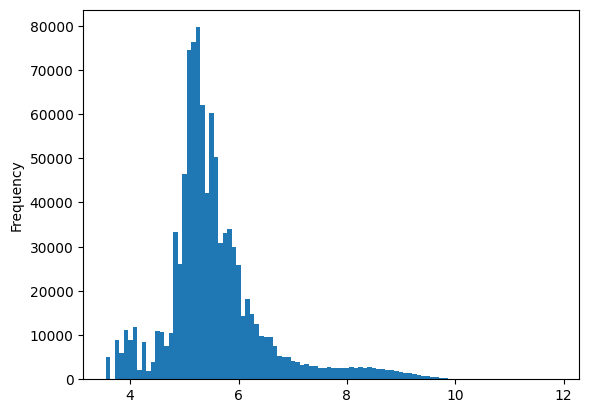

In [ ]:
df_train.head(1000000)["normalized_count"].plot.hist(bins=100)

In [ ]:
cell_types = ad_train.obs.cell_type.unique()
perturbations = ad_train.obs.sm_name.unique()

In [ ]:
ad_train[(ad_train.obs.cell_type==cell_types[1]) & (ad_train.obs.sm_name==perturbations[1]), :].shape

(54, 18211)

In [ ]:
data = np.nan * np.empty((len(perturbations), len(cell_types)))
df_stats = pd.DataFrame(data, index=perturbations, columns=cell_types)

In [ ]:
# fill out table with numbers of samples per condition and cell type
for idx in perturbations:
  for col in cell_types:
    df_stats.loc[idx, col] = ad_train[(ad_train.obs.cell_type==col) & (ad_train.obs.sm_name==idx), :].shape[0]

In [ ]:
df_stats

,T cells CD4+,T regulatory cells,NK cells,T cells CD8+,B cells,Myeloid cells
MLN 2238,697.0,1.0,4.0,392.0,2.0,5.0
BMS-265246,895.0,54.0,430.0,77.0,0.0,0.0
Resminostat,933.0,12.0,320.0,0.0,0.0,0.0
FK 866,532.0,46.0,260.0,62.0,0.0,0.0
Nilotinib,529.0,28.0,287.0,84.0,0.0,0.0
...,...,...,...,...,...,...
Crizotinib,506.0,37.0,305.0,87.0,215.0,117.0
BMS-387032,143.0,68.0,195.0,10.0,0.0,0.0
UNII-BXU45ZH6LI,257.0,16.0,28.0,6.0,0.0,0.0
Alvocidib,8.0,33.0,6.0,0.0,3.0,1.0


In [ ]:
sel_cells = ["T cells CD4+", "T regulatory cells",	"NK cells",	"T cells CD8+"]

In [ ]:
df_stats[sel_cells].sum(axis=1).sort_values(ascending=False)

Dimethyl Sulfoxide    18668.0
HMN-214                1514.0
Methotrexate           1482.0
Canertinib             1476.0
BMS-265246             1456.0
                       ...   
ABT737                  655.0
BMS-387032              416.0
UNII-BXU45ZH6LI         307.0
CGP 60474                89.0
Alvocidib                47.0
Length: 145, dtype: float64

In [ ]:
# Select perturbations with largest number of samples
sel_perturb = df_stats[sel_cells].sum(axis=1).sort_values(ascending=False).index[:11]

In [ ]:
# Number of samples per drug/cell_type
df_stats.loc[sel_perturb, sel_cells]

,T cells CD4+,T regulatory cells,NK cells,T cells CD8+
Dimethyl Sulfoxide,10778.0,812.0,5782.0,1296.0
HMN-214,920.0,61.0,457.0,76.0
Methotrexate,863.0,73.0,471.0,75.0
Canertinib,918.0,69.0,413.0,76.0
BMS-265246,895.0,54.0,430.0,77.0
Lapatinib,806.0,71.0,422.0,93.0
Ganetespib (STA-9090),544.0,4.0,779.0,12.0
Topotecan,765.0,74.0,414.0,79.0
Phenylbutazone,779.0,68.0,402.0,78.0
LDN 193189,813.0,55.0,385.0,74.0


In [ ]:
ad_train_sel = ad_train[ad_train.obs.sm_name.isin(sel_perturb) & ad_train.obs.cell_type.isin(sel_cells)]

In [ ]:
ad_train_sel.write(f"{DATA}/ad_train.top_drugs.h5ad", compression="gzip")

# Test (TMP)

In [ ]:
from anndata.experimental.pytorch import AnnLoader

In [ ]:
# Load the Anndata object
# adata = sc.read('data.h5ad')
# adata = ad.read('ad_train.sel.h5ad', backed='r')
# adata.file.close()


ad_train1 = ad.read_h5ad('ad_train.sel.h5ad')

In [ ]:
# Create a dataloader with a batch size of 128 and shuffle the data
dataloader = AnnLoader(ad_train1, batch_size=32, shuffle=True)

In [ ]:
for batch in tq.tqdm(dataloader):
    # Get the input data and labels
    batch = batch.X


100%|██████████| 393/393 [00:00<00:00, 523.35it/s]


In [ ]:
batch.shape

torch.Size([27, 18211])